In [26]:
import sys
sys.path.append('..')
import easyidp as idp

In [27]:
info_map = idp.jsonfile.read_json(r"Z:\hwang_Pro\data\2022_tanashi_broccoli\12_head_segment\broccoli_autumn21-20220405_0.json")

In [28]:
for k, v in info_map.items():
    print(k)
    break

1_DJI_0356


In [29]:
from torchvision import transforms
import imageio as io
from PIL import Image
import numpy as np
import torch
from bisenet.bisenetv2 import BiSeNetV2
import config
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = 'cuda' if torch.cuda.is_available==True else 'cpu'
model = BiSeNetV2(n_classes=2).to(device)

model_weight = torch.load(config.model_weight)
model_weight = model_weight["model_state_dict"]

model.load_state_dict(model_weight, strict=False)

transform = A.Compose([
        A.Resize(128, 128),
        # A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

def predict_batch(model, batch):
    """[summary]

    Args:
        model ([model]): [deeplab model]
        img ([list]): [batch of images]

    Returns:
        [type]: [description]
    """    
    model.eval()
    with torch.no_grad():
        
        batch.to(device)
        # print(img)
        pred, *_= model(batch)
        # print(pred.shape)
        masks = pred.permute(0, 2, 3, 1).detach().cpu().numpy()
        # images = batch.permute(0, 2, 3, 1).detach().cpu().numpy()
        # print(masks[0])
        # masks[masks >= 0.5] = 10
        # masks[masks < 0.5] = 255
        # print(masks.shape)
        print(masks[0])
        
        masks = masks.argmax(3).reshape(-1, 128, 128, 1)
        print(np.unique(masks))
        return np.array(masks, dtype=np.uint8)

In [30]:
values = info_map['2_DJI_0355']
croped_image_path = values['cropedImagePath']
print(croped_image_path)
coords = values['headCoordOnCroppedImage']
print(len(coords))
base = 75
img = io.imread(croped_image_path)
h, w, _ = img.shape
one_mask = np.zeros((h, w, 1), dtype=np.uint8)

# convert to numpy array
# points = np.array(coords, dtype=np.int32)
points = coords
# calcualte x0, y0, x1, y1
y0 = points[:, 1] - base
x0 = points[:, 0] - base
y1 = points[:, 1] + base
x1 = points[:, 0] + base
# avoid minus number
y0[y0 < 0] = 0
x0[x0 < 0] = 0
y1[y1 > h] = h
x1[x1 > w] = w

bboxs = np.array(list(zip(y0, x0, y1, x1)))
# get sub images
batch = []
for idx, (y_0, x_0, y_1, x_1) in enumerate(bboxs):
    if idx==9:
        sub_img = img[y_0:y_1, x_0:x_1, :3]
        sub_img = transform(image=sub_img)['image']
        batch.append(sub_img)

batch = torch.stack(batch)

Z:/hwang_Pro/data/2022_tanashi_broccoli/12_head_segment/broccoli_autumn21-20220405_0/2_DJI_0355.png
21


TypeError: list indices must be integers or slices, not tuple

In [40]:
exp = io.imread('./exp.png')[..., :3]
batch = torch.stack([transform(image=exp)['image']])

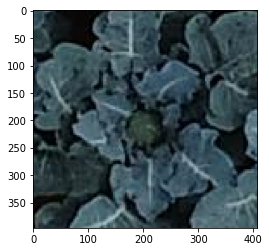

In [41]:
plt.imshow(exp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 128, 128])


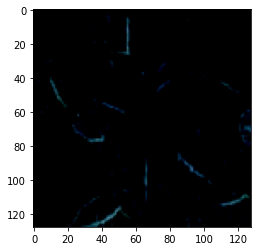

In [42]:
print(batch.shape)
idx = 0
tmp_img = batch[idx].permute(1,2,0)
import matplotlib.pyplot as plt
plt.imshow(tmp_img)

In [43]:
device = 'cuda' if torch.cuda.is_available==True else 'cpu'
model = BiSeNetV2(n_classes=2).to(device)

model_weight = torch.load(config.model_weight)
model_weight = model_weight["model_state_dict"]

model.load_state_dict(model_weight, strict=False)

model.eval()
with torch.no_grad():
    batch.to(device)
    pred, *_= model(batch)

In [44]:
masks = pred.permute(0, 2, 3, 1).detach().cpu().numpy()
masks = masks.argmax(3).reshape(-1, 128, 128, 1)

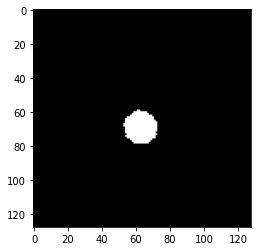

In [45]:
plt.imshow(masks[idx], cmap='gray')

In [53]:
# print(pred.shape)
masks = pred.permute(0, 2, 3, 1).detach().cpu().numpy()
masks = masks.argmax(3).reshape(-1, 128, 128, 1)
# print(np.unique(masks))
#paste back
for box, mask in zip(bboxs, masks):
    # print(np.unique(mask))
    y0, x0, y1, x1 = box
    # print(mask, mask.shape) 
    print(np.unique(mask))
    mask = transforms.Resize((y1-y0, x1-x0))(torch.tensor(mask).permute((2,0,1)))*255
    
    mask[mask > 50] = 255
    mask[mask <= 50] = 100
    # print('masks:', np.unique(mask))
    mask = np.asarray(mask).transpose((1,2,0))
    
    # print(mask.shape)
    one_mask[y0:y1, x0:x1, :] = mask
# print('test')
    io.imsave('./test.png', one_mask)

[0]


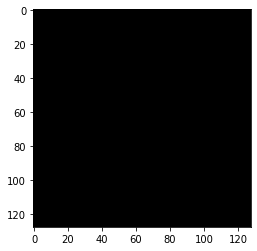

In [51]:
idx = 0
plt.imshow(masks[idx], cmap='gray')

In [44]:
croped_image_name, values = iter(info_map.items())
    croped_image_path = values['cropedImagePath']
    coords = values['headCoordOnCroppedImage']
    print(len(coords))
    base = 50
    img = io.imread(croped_image_path)
    # print(np.unique(img))
    h, w, _ = img.shape
    one_mask = np.zeros((h, w, 1), dtype=np.uint8)

    # convert to numpy array
    points = np.array(coords, dtype=np.int32)
    # calcualte x0, y0, x1, y1
    y0 = points[:, 1] - base
    x0 = points[:, 0] - base
    y1 = points[:, 1] + base
    x1 = points[:, 0] + base
    # avoid minus number
    y0[y0 < 0] = 0
    x0[x0 < 0] = 0
    y1[y1 > h] = h
    x1[x1 > w] = w
    
    bboxs = np.array(list(zip(y0, x0, y1, x1)))
    # get sub images
    batch = []
    for y_0, x_0, y_1, x_1 in bboxs:
        sub_img = img[y_0:y_1, x_0:x_1, :3]
        sub_img = transform(Image.fromarray(sub_img))
        sub_img = np.array(sub_img)
        batch.append(sub_img)
    batch = np.array(batch)
    batch = torch.from_numpy(batch)
    # print(batch.shape)
    # batch = torch.tensor(batch).permute((0, 3, 1, 2))
    
    # print(np.unique(batch))
    masks = predict_batch(model, batch)
    # print(np.unique(masks))
    # masks = np.array(masks, dtype=np.uint8)
    #paste back
    for box, mask in zip(bboxs, masks):
        # print(np.unique(mask))
        y0, x0, y1, x1 = box
        # print(mask, mask.shape) 
        mask = transforms.Resize((y1-y0, x1-x0))(torch.tensor(mask).permute((2,0,1)))*255
        mask[mask > 50] = 255
        mask[mask <= 50] = 100
        # print('masks:', np.unique(mask))
        mask = np.asarray(mask).transpose((1,2,0))
        
        # print(mask.shape)
        one_mask[y0:y1, x0:x1, :] = mask
    # print('test')
    io.imsave('./test.png', one_mask)
    break
    # return mask2polygon(one_mask[:, :, 0])


IndentationError: unexpected indent (2570751612.py, line 2)

In [52]:
for croped_image_name, values in info_map.items():
    croped_image_path = values['cropedImagePath']
    coords = values['headCoordOnCroppedImage']
    print(len(coords))
    base = 50
    img = io.imread(croped_image_path)
    # print(np.unique(img))
    h, w, _ = img.shape
    one_mask = np.zeros((h, w, 1), dtype=np.uint8)

    # convert to numpy array
    points = np.array(coords, dtype=np.int32)
    # calcualte x0, y0, x1, y1
    y0 = points[:, 1] - base
    x0 = points[:, 0] - base
    y1 = points[:, 1] + base
    x1 = points[:, 0] + base
    # avoid minus number
    y0[y0 < 0] = 0
    x0[x0 < 0] = 0
    y1[y1 > h] = h
    x1[x1 > w] = w
    
    bboxs = np.array(list(zip(y0, x0, y1, x1)))
    # get sub images
    batch = []
    for y_0, x_0, y_1, x_1 in bboxs:
        sub_img = img[y_0:y_1, x_0:x_1, :3]
        sub_img = transform(Image.fromarray(sub_img))
        sub_img = np.array(sub_img)
        batch.append(sub_img)
    batch = np.array(batch)
    batch = torch.from_numpy(batch)
    # print(batch.shape)
    # batch = torch.tensor(batch).permute((0, 3, 1, 2))
    
    # print(np.unique(batch))
    masks = predict_batch(model, batch)
    # print(np.unique(masks))
    # masks = np.array(masks, dtype=np.uint8)
    #paste back
    for box, mask in zip(bboxs, masks):
        # print(np.unique(mask))
        y0, x0, y1, x1 = box
        # print(mask, mask.shape) 
        mask = transforms.Resize((y1-y0, x1-x0))(torch.tensor(mask).permute((2,0,1)))*255
        mask[mask > 50] = 255
        mask[mask <= 50] = 100
        # print('masks:', np.unique(mask))
        mask = np.asarray(mask).transpose((1,2,0))
        
        # print(mask.shape)
        one_mask[y0:y1, x0:x1, :] = mask
    # print('test')
    io.imsave('./test.png', one_mask)
    break
    # return mask2polygon(one_mask[:, :, 0])


9
[0]


In [16]:
import pathlib
import config
config.img_dirs
path = pathlib.Path(config.img_dirs[0])
path.stem

'broccoli_autumn21-20220321_0'

In [17]:
json_path = path.parent / (path.name + '.json')

In [20]:
json_path.exists()

True